# Análise estatística de dados fluviométricos
## Reorganizar os dados da ANA 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter 
import seaborn as sns 

In [2]:
# Importar dados
path = "C:\\ENS\\Hidrologia"
dados = pd.read_excel(path+'\\86480000_Vazoes.xlsx')

# Identificar tipos de dados (Dtype) 
#dados.info() 

In [3]:
# Extrair dados de 1980 a 2015
dados = dados[dados['Data'] >= '1980-01-01']
dados = dados[dados['Data'] <= '2015-12-31']
dados = dados.reset_index().drop('index', axis='columns') 

In [4]:
# Verificar se todos os dados são consistidos
print('Todos os dados são consistidos?', 
      all(dados['NivelConsistencia'] == 2))

# Verificar se os dados contêm todos os meses de 1980 a 2015
datas = pd.date_range(start='1980-01-01', end='2015-12-31', freq='ME')
print('Contêm todos os meses?', 
      len(datas) == len(dados.index))

Todos os dados são consistidos? True
Contêm todos os meses? True


In [5]:
# Reorganizar os dados
dados = dados.drop('NivelConsistencia', axis='columns') 
dados = dados[::-1]
dados = dados.set_index('Data')
dados.columns = list(range(1, 32))

In [6]:
# Reorganizar as vazões diárias
ano_mes = lambda x: x.strftime('%Y-%m')
add_zero = lambda x: f'{0}{x}' if x<10 else x

datas = pd.date_range(start='1980-01-01', end='2015-12-31', freq='D')
aux = pd.DataFrame()
aux['Data'] = [data.strftime('%Y-%m-%d') for data in datas]
aux['Vazão'] = [0.0]*len(aux['Data'])
linha = 0
for i in range(len(dados.index)):
    for j in range(len(dados.columns)):
        dia = str(ano_mes(dados.index[i]))+'-'+str(add_zero(dados.columns[j]))
        if dia == aux.loc[linha, 'Data']:
            aux.loc[linha, 'Vazão'] = dados.iloc[i, j]
        else:
            continue
        linha = linha+1
aux.replace(0.0, 'NaN', inplace=True) 
aux['Data'] = pd.to_datetime(aux['Data'], format='%Y-%m-%d')
aux = aux.set_index('Data')
aux['log(Vazão)'] = np.log10(aux['Vazão'])
aux.to_excel(path+'\\Dados_ANA.xlsx') 

In [7]:
aux.head()

,Vazão,log(Vazão)
Data,,
1980-01-01,14.9940,1.175918
1980-01-02,13.8888,1.142665
1980-01-03,12.8170,1.107786
1980-01-04,11.2734,1.052055
1980-01-05,9.8087,0.991611


## Hidrograma

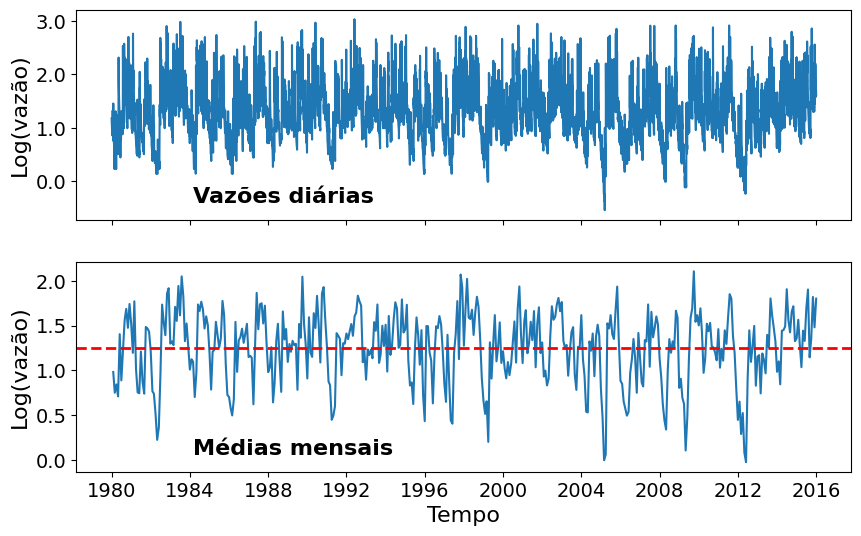

In [9]:
# Hidrogramas diário e mensal
media_mensal = aux.resample('ME').mean()

fig,ax = plt.subplots(2, sharex=True, figsize=(10, 6))
ax[0].plot(aux['log(Vazão)'])
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
ax[0].set_ylabel('Log(vazão)', fontsize=16)

ax[1].plot(media_mensal['log(Vazão)'])
ax[1].set_ylabel('Log(vazão)', fontsize=16)

ax[1].axhline(media_mensal['log(Vazão)'].mean(),
              linestyle='--', 
              linewidth=2,
              color='red')

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.xlabel('Tempo', fontsize=16) 
font = {'fontsize':16, 'fontweight':'bold'}
plt.text(0.15, 1.28,'Vazões diárias', font, transform=plt.gca().transAxes)
plt.text(0.15, 0.08,'Médias mensais', font, transform=plt.gca().transAxes)
plt.savefig(path+'\\hidrogramas.png', bbox_inches='tight')

## Histograma 

In [10]:
# Sturges
n = len(aux['log(Vazão)'])
k = 1 + (3.33*np.log10(n)) 
print('k = ', k) 

k =  14.715912775494159


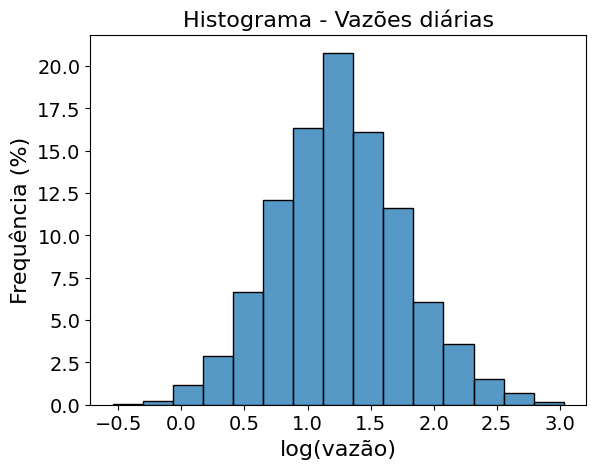

In [11]:
# Histograma diário
fig, ax = plt.subplots() 
data = aux['log(Vazão)']
num_bins = 15 # k arredondado
counts, bin_edges = np.histogram(data, bins=num_bins)

sns.histplot(data=aux, 
             x=aux['log(Vazão)'], 
             stat="percent",
             bins=bin_edges) 

plt.title('Histograma - Vazões diárias', fontsize=16) 
plt.xlabel('log(vazão)', fontsize=16) 
plt.ylabel('Frequência (%)', fontsize=16) 
plt.savefig(path+'\\hist_diario.png', bbox_inches='tight')

## Climatologia

In [12]:
# Vazões
aux['Mês'] = aux.index.month
aux1 = aux.groupby('Mês').mean() 

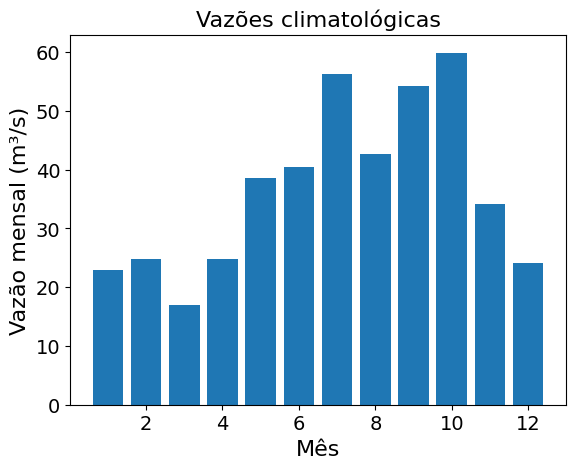

In [13]:
fig, ax = plt.subplots() 
ax.bar(aux1.index, aux1['Vazão'])
ax.set_xlabel('Mês', fontsize=16)
ax.set_ylabel('Vazão mensal (m\u00b3/s)', fontsize=16)
plt.title('Vazões climatológicas', fontsize=16) 
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.savefig(path+'\\vazao_climatologica.png', bbox_inches='tight')

In [14]:
# Precipitação 
path = "C:\\ENS\\Hidrologia\\Dados_INMet"
dados = pd.read_excel(path+'\\Normais_1981_2010.xlsx').set_index('Mês')

https://portal.inmet.gov.br/normais# <br>
Período: 1981-2010 <br>
Precipitação Acumulada Mensal e Anual <br>
Estação Lagoa Vermelha (RS) - Código 83916 

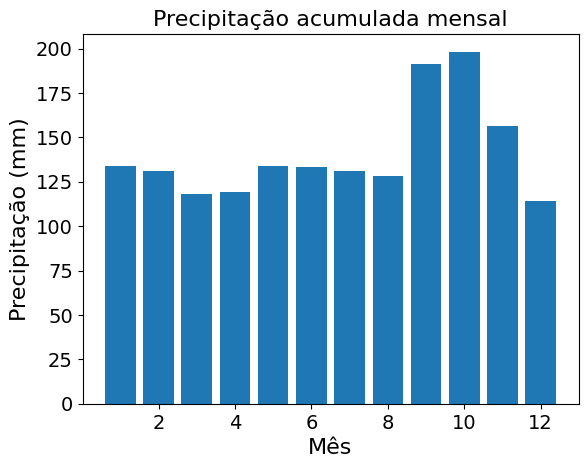

In [15]:
fig, ax = plt.subplots() 
ax.bar(dados.index, dados['Precipitação (mm)'])
ax.set_xlabel('Mês', fontsize=16)
ax.set_ylabel('Precipitação (mm)', fontsize=16)
plt.title('Precipitação acumulada mensal', fontsize=16) 
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.savefig(path+'\\normal_inmet.png', bbox_inches='tight')